# Mock Data for Compressed Matrices



### taken from `https://github.com/bamler-lab/webgl-entropy-coding`

## File Format Specification

We store $K$ compressed matrices $W_0, \dots, W_{K-1}$, and a single uncompressed vector $v_0$.

- For $k \in \{0, \ldots, K-1\}$, the matrix $W_k$ has dimension $N_{k+1} \times N_k$.
- The vector $v_0$ has dimension $N_0$.

Thus, the statement $v_K := W_{K-1} W_{K-2} \ldots W_0 v_0$ denotes a valid sequence of matrix-vector multiplications with matching dimensions, resulting in a vector $v_K$ with dimension $N_K$.

### Overall Container Format

The overall file layout is structured as follows:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K   &\texttt{result\_hash} & S_\text{max} & N_0 &  v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32 & u32          & u32 & u32& i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

Here,

- `u<X>` (e.g., $u8$, $u32$) denotes an unsigned $X$-bit integer value;
- `i<X>` (e.g., $i8$) denotes a signed $X$-bit integer value;
- $\texttt{result\_hash}$ contains a 32-bit hash of the final result vector to verify correctness in the kernel
- all numbers are stored in little endian byte order;
- `{u, i}<X>[size]`, i.e., a type followed by braces (e.g., $i8[N_0]$) denotes a densely packed array of `size` elements of the same type;
- $S_\text{max}$ is the maximum size of the compressed representation (see below) of any of the involved matrices $W_0, \ldots, W_{K-1}$, including matrix headers (as described below), measured in units of 16 bit (2 byte).
- `pad` contains either 0, 1, 2, or 3 bytes whose values will be ignored by the decoder;
  its length $l_\text{pad} \in \{0,1,2,3\}$ is determined such that $N_0 + l_\text{pad}$ is an integer multiple of $4$, so that the subsequent fields can be 32-bit aligned;
- the compressed representation of the matrices $W_0, \ldots, W_{K-1}$ is detailed below.

### Matrix Container Format

In the above overall container format, each matrix $W_k$ for $k\in \{0,\ldots,K-1\}$ is stored in the following layout:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta & \texttt{cursors} & \texttt{payload\_size} & \hat{w}_\text{min} & |G| & \texttt{cdf} & \texttt{pad} & \texttt{ppf}& \texttt{payload} \\ \hline
      \text{type:} & u32   & u32     & f32    & u32[N_{k+1}]     & u32                    & i8                 & u8  & u8[|G| + 1]  &  u8[(|G|+1) \operatorname{mod} 2]     & u8[256] & u16[\texttt{payload\_size}] \\ \hline
  \end{array}
$

- ~~**TODO:**~~ maybe we should flush the coders after each matrix. The overhead is negligible (32 bit per matrix row, i.e., same as the overhead for the `cursors`)  **&#x2611;** (done in the `interrupt` method of ANSCoder, 11.09.2025)

Here,

- $\delta$ is the distance between neighboring grid points; i.e., if $\hat{W}_k \in \mathbb{Z}^{N_{k+1}\times N_k}$ is the integer representation of the decoded quantized matrix, then the true quantized matrix is $W_k = \delta \hat{W}_k$, and thus, for a vector-matrix multiplication $v_{k+1} := W_k v_k$, we have $v_{k+1} = \delta \hat{v}_{k+1}$ where $\hat{v}_{k+1} := \hat{W}_k v_k$.
- `cursors` is an array of the size of the output dimension $N_{k+1}$ which, for each matrix row, contains an offset into `payload` where additional compressed data for this matrix row (if needed) starts; offsets are measured in units of 16 bit (2 byte), and relative to the start of the `payload` field (thus, `cursors[0]` is always `0`);
- `payload_size` is the length of the `payload` field, measured in units of 16 bit (2 byte);
  since the `payload_size` field directly follows the `cursors` field, `payload_size` can be interpreted as an $(N_{k+1}+1)$-th cursor pointing to where the compressed data for an additional matrix row would start if there was one more matrix row.
  - Due to payload padding (see below), `payload_size` is always even (so that all compressed matrix structs are 32-bit aligned).
- $\hat{w}_\text{min}$ is the smallest value present in the integer representation $\hat{W}_k$ of the quantized matrix.
- $|G|$ is the grid size; we assume a uniform grid, i.e., the integer representation $\hat{W}_k$ of the quantized matrix takes only values from the range $\{\hat{w}_\text{min}, {\hat{w}_\text{min} + 1}, \ldots, {\hat{w}_\text{min} + |G| - 1}\}$.
- `cdf` is the cumulative distribution function of the entropy model in 8-bit unsigned integer representation.
  Its interpretation is that it defines a probability mass function (PMF) via $\texttt{pmf}[r] := (\texttt{cdf}[r + 1] - \texttt{cdf}[r]) \operatorname{mod} 2^8 \;\forall r \in \{0, 1, \ldots, |G|-1\}$.
  Here, the "$\operatorname{mod} 2^8$" wraps only for the last entry, $\texttt{pmf}[|G|-1] = {(0 - \texttt{cdf}[r]) \operatorname{mod} 2^8} = 2^8 - \texttt{cdf}[|G|-1]$, which is enforced by the requirements $\texttt{cdf}[|G|] = 0$ and $\texttt{cdf}[|G|-1] > 0$, see below, and the fact that $\texttt{cdf}[|G|-1] < 2^8$ since $\texttt{cdf}[|G|-1]$ is an unsigned 8-bit integer.
  The `cdf` it satisfies the following properties:
  - The first $|G|$ entries of `cdf` make up a nonincreasing sequence: `cdf[0] <= cdf[1] <= ... <= cdf[|G| - 1]`.
  - `cdf[0] = cdf[|G|] = 0`.
  - `cdf[|G| - 1] > 0` (which implies that $|G| \geq 2$ since `cdf[0] = 0`);
    thus, the entropy model must not represent a delta distribution that puts all probability mass on a single grid point;
    this requirement enables a simplification in the implementation of the ANS algorithm while anyway only affecting the pathological edge case where all matrix elements of $\hat{W}_k$ are equal.
    This pathological edge case can still be treated efficiently, e.g., by setting $|G|=2$, setting $\hat{w}_\text{min}$ to the value taken by all matrix elements, and setting $\texttt{cdf} = [0, 255, 0]$.
    With these settings, the entropy model puts almost all probability mass on the entry taken by all matrix elements and only a tiny probability mass on an irrelevant dummy grid point, resulting in a cross entropy of $\log_2(\frac{256}{255}) \approx 0.0056$ bit per matrix element.
  - If `cdf[r] = cdf[r + 1]` for some $r \in \{0, \ldots, {|G|-2}\}$, then this means that the entropy model assigns zero probability mass to the value ${\hat{w}_\text{min} + r}$, and therefore $\hat{W}_k$ must not contain any matrix entry with value ${\hat{w}_\text{min} + r}$ because this value cannot be encoded with this entropy model.
- `pad` is either nothing or a single byte with arbitrary value that should be ignored by the decoder.
  This byte is inserted if the grid size $|G|$ is even to ensure that the `payload` can be properly 16-bit aligned.
- `payload` contains the compressed data, see below.

### Compressed Bit String Representation & Decoding

We define the format of the `payload` field in the above matrix container format by specifying the decoding process.
The encoding algorithm follows from this specification as encoding is inference over a decoder.

When decoding the $k$-th matrix with dimensions $N_{k+1}\times N_k$, the decoder operates on the $N_{k+1}$ matrices independently (and thus, possibly in parallel).
All decoders need read access to the shared `cdf` of the entropy model, the shared `payload` of the compressed matrix, and a coder-specific cursor $C_i$ that gets initialized at the beginning of each matrix-decoding process from `cursor[i]` declared in the matrix container format.
A practical implementation will likely also want to create a shared `ppf` lookup table that stores the inverse of `cdf` to speed up steps 2 and 3 below.

Decoding the $i$-th row of matrix $W_k$ works as follows:

- Initialize the row's cursor $C_i \gets \texttt{cursors}[i]$, where `cursors` is a field of the matrix container format specified above.
- Initialize an unsigned 32-bit coder state $S_i \gets (\texttt{payload}[C_i] \ll 16) \;|\; \texttt{payload}[C_i+1]$, where "$\ll$" denotes left bit-shift and "$|$" denotes bitwise or.
  Thus, the 32-bit coder state $S_i$ is initialized to the concatenation of the first two 16-bit words read off the `payload` starting from the row's initial cursor.
- Increment the curser accordingly: $C_i \gets C_i + 2$.
- For each column $j \in \{0,\ldots,N_k-1\}$ (in ascending order) do:
  1. Set `quantile` ← least significant 8 bits of the coder state $S_i$
  2. Set `r` to the uniquely defined number in $\{0,\ldots,|G|-1\}$ such that `cdf[r] <= quantile < cdf[r+1]`.
  3. Set the (integer representation of the) decoded matrix element to $(\hat{W}_k)_{ij} \gets r + \hat{w}_\text{min}$.
  4. Update the coder state $S_i \gets (S_i \gg 8) \times$ `((cdf[r+1] - cdf[r]) mod 256)` + `(quantile - cdf[r])`,
     where "$\gg$" denotes left bit shift (that is _unsigned_, i.e., it fills from the right with zero bits).
  5. If $S_i < 2^{16}$ (i.e., if the 16 most significant bits of the 32-bit number $S_i$ are all zero, or, equivalently, if $(S_i \gg 16) = 0$), then:
     - Update $S_i \gets (S_i \ll 16) \;|\; \texttt{payload}[C_i]$,
       where "$\ll$" denotes left bit shift, and "$|$" denotes bitwise `or` (this update can be understood as concatenating $\texttt{payload}[C_i]$ to $S_i$ since $\texttt{payload}[C_i]$ is a 16-bit unsigned integer).
     - Increment $C_i \gets C_i + 1$.

### Encoding

A valid encoder is any program that generates a file in the format specified above such that decoding the file with the decoding algorithm specified above generates the desired (quantized) matrices $\hat{W}_0, \ldots, \hat{W}_{K-1}$.

In practice, encoding a quantized matrix $W_k$ of shape $N_{k+1} \times N_k$ can be performed as follows:

- Prepare an integer representation $\hat{W}_k \in \mathbb{Z}^{N_k \times N_{k+1}}$ of the quantized matrix and determine its minimum $\hat{w}_\text{min} := \min_{i,j} (\hat{W}_k)_{ij}$ and grid size $|G| := \max_{i,j} (\hat{W}_k)_{ij} - \hat{w}_\text{min} + 1 \ge 2$.
- Prepare a suitable `cdf` for $\hat{W}_k$.
- Initialize `reverse_payload` ← empty growable array of `u16`.
- For each row $i \in \{0,\ldots,N_{k+1}-1\}$ in _descending_ order, do (note: this could be parallelized without changing the result):
  - Initialize an unsigned 32-bit coder state $S \gets 2^{16}$.
  - For each column $j \in \{0,\ldots,N_k-1\}$ in _descending_ order, do:
    1. Set $r \gets (\hat{W}_k)_{ij} - \hat{w}_\text{min}$; (thus, $r \in \{0,\ldots, |G|-1\}$).
    2. Set `probability ← (cdf[r+1] - cdf[r]) mod 256`.
    3. If $(S \gg 24) \geq \texttt{probability}$ (i.e., if dividing $S$ by `probability` and then shifting it by 8 bit to the left would overflow its 32-bit size):
       - Push the 16 least significant bits of $S$ to the end of `reverse_payload`.
       - Update $S \gets (S \gg 16)$.
    4. Set $\texttt{quantile} \gets \texttt{cdf}[r] + (S \,\operatorname{mod}\, \texttt{probability})$;
       thus, $\texttt{quantile} \in \{0, \ldots, 255\}$.
    5. Update $S \gets (\lfloor S / \texttt{probability} \rfloor \ll 8) \;|\; \texttt{quantile}$,
       where "$\lfloor \,\cdot\,\rfloor$" denotes rounding down to an integer.
  - Push first the least significant 16 bit and then the most significant 16 bit of $S$ to the end of `reverse_payload`.
  - Set `back_cursor[i] ← length(reverse_payload)`, where length is measured in units of 16 bit.
- Obtain `payload` by reversing the order of elements in the array `reverse_payload`.
- For each $i \in \{0,\ldots,N_{k+1}-1\}$, set `cursor[i] ← length(payload) - back_cursor[i]`.
  Thus, we should have `cursor[0] = 0`.
- if `payload` has an odd length (i.e., contains an odd number of `u16`s), then append a single additional `u16` with arbitrary value (e.g., zero) to it to make it an even length.

In [103]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import struct
import sys

## Create Random Quantized Matrices

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


mins: [-127 -119 -127 -119 -119 -127 -127 -119 -127 -127 -127 -127 -110 -119
 -127 -119 -127 -127 -127 -119]
maxs: [127 127 110 127 127 127 127 127 127 127 119 127 127 127 119 127 127 127
 127 127]
Entropy in bits: 3.5442941650236106


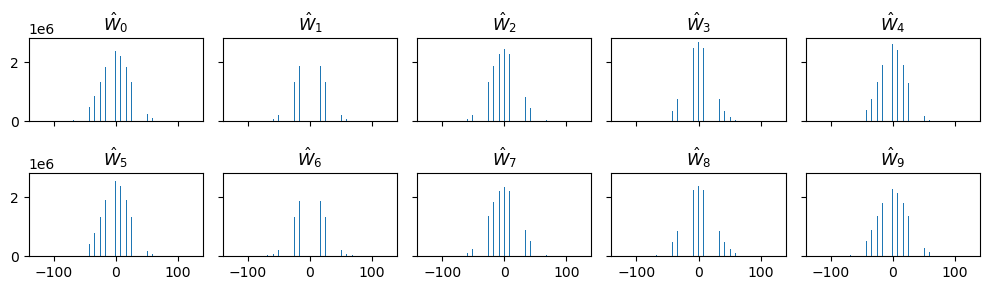

In [104]:
np.random.seed(20250310)

w = 4096
sigma = 1/np.sqrt(w)
n = 20
precision = 8

entropy = 5 # upper bound of entropy 

quantized_matrices = np.empty((n,w,w), dtype=np.int8)
w_deltas = np.zeros(n)
for i in tqdm(range(n)):
    matrix = np.random.randn(w, w)* sigma
    max_value = (2**(entropy-1))-1 # for signed integer maximum value is (2**(entropy-1))-1, neglecting -2**(entropy-1)
    w_delta =  np.abs(matrix).max()/max_value  # quantize matrices to int8 grid
    w_deltas[i] = w_delta # store as weight delta
    quantized_matrices[i,...] = np.round(np.round( matrix/ w_delta ) * 127 / max_value).astype(np.int8)

print(f'mins: {quantized_matrices.min(axis=(1, 2))}')
print(f'maxs: {quantized_matrices.max(axis=(1, 2))}')

fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i) + r'}$')

vector = np.round(np.random.randn(w) * 4).astype(np.int8)


values, counts = np.unique(quantized_matrices[0], return_counts=True)
probs = counts/ counts.sum()
print(f"Entropy in bits: {probs @ -np.log2(probs)}")

In [105]:
def hash_int8_array(arr):
    """Simple hasher adopted from the "FxHash" rust crate.
    Not cryptographically secure, but _accidental_ collisions are very unlikely."""

    assert arr.dtype == np.int8

    hash = 0
    for byte in arr.astype(np.uint8).ravel():
        # rotate left by 5 bits
        hash = ((hash >> 27) | (hash << 5)) & 0xffff_ffff
        hash = ((hash ^ byte.item()) * 0x2722_0a95) & 0xffff_ffff

    return hash

## Calculate Result in python

In [106]:

v_delta = 1
v_int8 = vector.copy()
for i,mat in enumerate(quantized_matrices):
    # .astype(np.int32) to not overflow while accumulating
    v_int32 = (mat.astype(float) @ v_int8.astype(float))
    # print(v_int32)
    
    # multiply w_deltas and v_delta to scale back to original values
    v_f32 = v_int32 * w_deltas[i] * v_delta

    # requantization to align again to  int8 
    v_delta = np.abs(v_f32).max() / 127 

    v_int8 = (v_f32 / v_delta)
    v_int8 = np.round(v_int8) # rounding for quantization
    # print(hash_int8_array(v_int8.astype(np.int8)))

final_result = v_int8
print(list(v_int8))
result_hash = hash_int8_array(np.array(final_result,dtype=np.int8))
print(result_hash)

[13.0, 34.0, 10.0, -18.0, 14.0, 30.0, 0.0, -9.0, -21.0, 106.0, 124.0, 65.0, -28.0, 0.0, -52.0, -7.0, 22.0, 26.0, -14.0, -43.0, 12.0, -66.0, -0.0, -4.0, -16.0, 19.0, -31.0, 22.0, -6.0, -46.0, -9.0, -3.0, 18.0, 4.0, -19.0, 5.0, 36.0, 5.0, 78.0, -46.0, 2.0, -1.0, -62.0, -25.0, -2.0, 1.0, 14.0, -21.0, -88.0, 29.0, -42.0, -14.0, 49.0, -35.0, -12.0, 52.0, 47.0, 22.0, -12.0, 7.0, 60.0, -34.0, -47.0, -25.0, 63.0, -27.0, 15.0, 9.0, 24.0, 57.0, 11.0, 21.0, -19.0, 99.0, -16.0, -29.0, -31.0, -17.0, -43.0, 6.0, 8.0, -7.0, -12.0, 1.0, 25.0, -68.0, 3.0, 43.0, 6.0, -8.0, -58.0, -24.0, 18.0, -29.0, -29.0, -18.0, -47.0, 25.0, 68.0, -3.0, 61.0, -43.0, 1.0, 7.0, -61.0, 43.0, -72.0, 21.0, 30.0, 19.0, -11.0, -23.0, 83.0, 36.0, -89.0, -33.0, 0.0, -7.0, -19.0, -85.0, 49.0, 24.0, -37.0, 71.0, 18.0, -16.0, -65.0, -26.0, -78.0, 53.0, 52.0, 22.0, 35.0, 10.0, 14.0, 27.0, -19.0, 30.0, 15.0, -70.0, 45.0, -57.0, 80.0, -6.0, 28.0, -35.0, 19.0, -7.0, -8.0, -45.0, 20.0, 22.0, 7.0, 5.0, 43.0, -34.0, -39.0, -52.0, -9.0, 1

## Write `raw-matrices.bin` for baseline comparison
Uses the same overall container format but stores matrix elements in column major ordering

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K    &  \texttt{result\_hash} & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32  & u32 & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

$
  \begin{array}{|r||c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta &    \texttt{payload} & \texttt{padding} \\ \hline
      \text{type:} & u32   & u32     & f32    &  i8[N_{k+1}N_k]  & i8[N_{k+1}N_k mod 2]  \\ \hline
  \end{array}
$ 

If the number of rows or columns is not divisible by 2 the last byte of `payload` is padded with zeros.

In [107]:
def serialize_file_header_raw(file, num_matrices, result_hash): # omitting max word count
    print(f"Num_matrices: {num_matrices}")
    file.write(struct.pack('<LL', num_matrices, result_hash))

def serialize_vector_raw(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

def serialize_raw_matrix(file, matrix):

    file.write(struct.pack(
        f'<LLf',
        *matrix.shape,1.))

    if sys.byteorder == 'little': 
        matrix.flatten(order="C").astype(np.int8).tofile(file) # C for C-Style saves matrix in row major format
    else:
        matrix.flatten(order="C").astype(np.int8).byteswap().tofile(file)

    if matrix.size % 2 != 0: 
        file.write(b'\0') # padding for if matrix does not have an even amount of 


with open(f"raw-matrices_{w}.bin", 'wb') as file:
    serialize_file_header_raw(file, len(quantized_matrices), result_hash)
    serialize_vector_raw(file, vector)
    for matrix in quantized_matrices:
        serialize_raw_matrix(file, matrix)

Num_matrices: 20
len_v: 4096


## Create Entropy Models

In [108]:
def create_entropy_model(data, precision):
    min_value = data.min().item()
    max_value = data.max().item()

    if min_value == max_value:
        # Special case: all values are the same. Due to a limitation of ANS coding, we have
        # to create a dummy extra grid point with the smallest possible nonzero probability.
        grid_size = 2
        cdf = np.array([0, (1 << precision) - 1, 1 << precision], dtype=np.uint16)
        entropy = 0
        # To avoid loss of precision, we use `log1p(x) := log(1 + x)`, and thus:
        # cross_entropy = - log2((2^p - 1) / 2^p) = - log2(1 - 1 / 2^p) = - log1p(-1 / 2^p) / log(2)
        cross_entropy = - np.log1p(-1 / (1 << precision)) / np.log(2)
    else:
        grid_size = max_value - min_value + 1
        values, counts = np.unique(data, return_counts=True)

        # Sort descendingly by `counts`.
        order = np.argsort(counts)[::-1]
        values = values[order]
        counts = counts[order]

        scale = (1 << precision) / data.size
        quantized_counts = np.maximum(1, np.round(counts * scale).astype(np.uint16))

        excess = sum(quantized_counts).item() - (1 << precision)
        if excess > 0:
            # Shave off some probability mass from the most probable entries
            assert excess <= len(counts)
            while excess > 0:
                num_reducible_entries = (quantized_counts > 1).sum()
                num_reduce = min(excess, num_reducible_entries)
                assert num_reduce > 0
                quantized_counts[:num_reduce] -= 1
                excess -= num_reduce
            quantized_counts[:excess] -= 1
        elif excess < 0:
            # Spread some probability mass to the least probable entries.
            assert -excess <=len(counts)
            quantized_counts[excess:] += 1

        assert quantized_counts.sum() == 1 << precision


        # see https://github.com/wildug/gpu-comp/wiki for a derivation
        entropy = np.log2(data.size) - (counts @ np.log2(counts)) / data.size 
        cross_entropy = precision - (counts @ np.log2(quantized_counts)) / data.size

        padded_pmf = np.zeros(grid_size + 1, dtype=np.uint16)
        for value, prob in zip(values, quantized_counts):
            padded_pmf[value - min_value + 1] = prob

        cdf = np.cumsum(padded_pmf, dtype=np.uint16)
        assert cdf[0] == 0
        assert cdf[-1] == 1 << precision

    return min_value, grid_size, cdf, entropy, cross_entropy

In [109]:
def create_ppf(cdf, p_precision= 8):
    # handcrafet for 8 bit precision (weights && probs)
    # TODO generalize to arbitrary weight and prob precisions

    ppf = np.zeros((1<<p_precision), dtype=np.uint8) # ppf is of size 2**p_prec
    # for each possible probability save its corresponding value of the cdf
    for p in range ((1<< p_precision)):
        for r in range(len(cdf)-1,0,-1):
            if (cdf[r-1] & 0xFF).astype(np.uint8) <=p:
                ppf[p]= r-1
                break
            


    # ppf[1<<p_precision] = len(cdf) -1
        

    assert ppf[-1] == len(cdf)-2 # for 8-bit integer weights
    assert ppf[0] == 0
    return ppf
            

In [110]:
# for i,m in enumerate(quantized_matrices):
#     min_value, grid_size, cdf, entropy, cross_entropy = create_entropy_model(m, 8)
#     ppf = create_ppf(cdf)


#     plt.plot([cdf[w] for w in ppf], label=f"{i}")
# print(len(cdf))
# print(len(ppf))

## Entropy Coder

In [111]:
class AnsCoder:
    def __init__(self, precision, word_size,  compressed=[], head_size=2):
        # int head_size determines the size of the coder head as multiples of word_size bits
        self.precision = precision
        self.word_size = word_size
        self.word_mask = (1 << word_size) - 1
        self.quantile_mask = (1 << precision) - 1
        self.bulk = compressed.copy()
        self.head = 0
        self.head_size = head_size
        self.head_mask = (1 << (word_size * head_size)) - 1
        # while len(self.bulk) != 0 and (self.head >>(self.word_size)*(self.head_size-1)) == 0:
        #     self.head = ((self.head << word_size) | int(self.bulk.pop())) & self.head_mask
        if compressed == []:
            self.bulk = [0] * (head_size-1) + [1]
        if len(compressed)>= self.head_size:
            for i in range(self.head_size):
                self.head = ((self.head << word_size) | int(self.bulk.pop())) & self.head_mask

    def push(self, symbol, cdf):
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        # this condition is true if the bits-back-trick would overflow the (head_size*word_size) bits, 
        # since z (arbitrary point between left cdf[symbol] and right cdf[symbol]) < prob
        if (self.head >> (self.head_size * self.word_size - self.precision)) >= prob:
            # i = 0
            while ((self.head >> (self.word_size)) != 0):
                self.bulk.append(self.head & self.word_mask)
                self.head >>= self.word_size
            #     i+=1
            # for i in range(self.head_size-1):
            #     self.bulk.append(self.head & self.word_mask)
            #     self.head >>= self.word_size

            # print(f"Pushed {i} times in a row")

        # print(f'pushing {symbol} with prob {prob} and cdf {cdf[symbol]} onto {self.head}')
        z = self.head % prob + cdf[symbol].item()
        self.head = (((self.head // prob) << self.precision) | z) & self.head_mask

    def pop(self, cdf, ppf):
        z = self.head & self.quantile_mask
        self.head >>= self.precision
        # symbol = cdf.searchsorted(z, side='right').item() - 1
        symbol = ppf[z]
        prob = ((cdf[symbol + 1] - cdf[symbol]).item()) & 0xFF
        self.head = self.head * prob + (z - cdf[symbol].item()) & self.head_mask
        if ((self.head >> (self.word_size)) == 0) and len(self.bulk) != 0:
            # this while loops runs head_size -1 times if bulk is nice, bulk should be nice
            while ((self.head >> (self.head_size-1)*(self.word_size)) == 0) and len(self.bulk) != 0:
                self.head = ((self.head << self.word_size ) | int(self.bulk.pop())) & self.head_mask
            # for i in range(self.head_size-1):
            #     self.head = ((self.head << self.word_size ) | int(self.bulk.pop())) & self.head_mask

        return symbol

    
    def interrupt(self):
        for i in range(self.head_size):
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size
        self.head = 1 << self.word_size  # restores invariant
        return len(self.bulk)

## Compress the Matrices

In [112]:
class CompressedMatrix:
    def __init__(self, rows, cols, grid_spacing, cursors, min_value, cdf,ppf, payload):
        self.rows = rows
        self.cols = cols
        self.grid_spacing = grid_spacing
        self.cursors = cursors
        self.min_value = min_value
        self.cdf = (cdf & 0xFF).astype(np.uint8) # only take lowest 8 bit
        self.ppf= (ppf & 0xFF).astype(np.uint8)

        self.payload = payload # unpadded; will be padded to an even length upon serialization.
    
    def compressed_word_count(self):
        evend_payload_size = len(self.payload) + len(self.payload) % 2
        return (4 + self.rows) * 2 + (3 + len(self.cdf)) // 2 + evend_payload_size

    def serialize(self, file):
        payload_size = len(self.payload) 
        file.write(struct.pack(
            f'<LLf{self.rows}LLbB{len(self.cdf)}B',
            self.rows,
            self.cols,
            self.grid_spacing,
            *self.cursors,
            payload_size,
            self.min_value,
            len(self.cdf) - 1,
            *(self.cdf),
        ))

        if len(self.cdf) % 2 == 1:
            file.write(b'\0')
        
        # writing ppf 
        file.write(struct.pack(
            f'<256B',*(self.ppf)
        ))

        if sys.byteorder == 'little':
            self.payload.tofile(file)
        else:
            self.payload.byteswap().tofile(file)

        if len(self.payload) % 2 == 1:
            file.write(b'\0\0')
    
    @staticmethod
    def deserialize(file):
        """ Reads binary data from a file and reconstructs a CompressedMatrix object """
        # read number of rows and columns and grid_spacing
        rows, cols, grid_spacing = struct.unpack("<LLf", file.read(12))

        # get cursors using number of rows
        cursors = np.fromfile(file, dtype=np.uint32, count=rows) #check
        
        # get payload size
        payload_size, min_value, G = struct.unpack("<LbB",file.read(6))
        
        # Read the CDF values
        cdf_len = G + 1
        cdf_data = np.fromfile(file, dtype=np.uint8, count=cdf_len)
        if cdf_len % 2 == 1:
            file.seek(1,1)

        ppf = np.fromfile(file, dtype=np.uint8, count=256)
        # read payload
        payload = np.fromfile(file, dtype=np.uint16, count=payload_size)

        # skip 2 bytes if payload is an uneven number of 
        if payload_size % 2 ==1:
            file.seek(2,1)           

        # If system is big-endian, swap bytes
        if sys.byteorder != 'little':
            payload = payload.byteswap()

        return CompressedMatrix(rows, cols, grid_spacing, cursors, min_value, cdf_data,ppf, payload)

In [113]:
j = 1
chunk_mat = np.empty((w,16*(1+w//512)),dtype=np.int8)
for idx, i in enumerate(range(0,quantized_matrices[0].shape[0],512)):
    chunk_mat[:,idx*16:(idx+1)*16] = quantized_matrices[0,...,(j*16)+i:(j*16)+i+16]

print(chunk_mat)
print(chunk_mat.shape)
print(quantized_matrices[0,:,:16],quantized_matrices[0,:,:16].shape)
# print(np.all(chunk_mat[:,16:32]== quantized_matrices[0,:,528:544]))

[[ 42 -17   8 ...  -1  -1  -1]
 [-25   8  25 ...  -1  -1  -1]
 [ -8 -34   8 ...  -1  -1  -1]
 ...
 [  0 -17  34 ...  -1  -1  -1]
 [-42   8  42 ...  -1  -1  -1]
 [  0 -34   8 ...  -1  -1  -1]]
(4096, 144)
[[ 34 -25   8 ... -34   8   0]
 [  8   0   0 ...  17   8  51]
 [ 42 -17 -59 ...   8   8 -17]
 ...
 [ 25  51 -17 ...  34   8 -68]
 [ 34  -8   0 ... -25   8 -34]
 [ -8  17   0 ...  17   8   8]] (4096, 16)


In [114]:
def encode_matrix(matrix, precision = 8):
    min_value, _grid_size, cdf, _entropy, _cross_entropy = create_entropy_model(matrix, precision)
    print(f"Entropy of matrix:       {_entropy:.4f} bits" )
    print(f"Cross-entropy of matrix: {_cross_entropy:.4f} bits (overhead of {(_cross_entropy/_entropy)-1:.4%} to Entropy)" )
    ppf = create_ppf(cdf)
    # print(len(cdf))

    back_cursors = np.empty(matrix.shape[0], dtype=np.uint32)

    chunk_mat = np.empty((w,16*((w+(32*16)-1)//(32*16))),dtype=np.int8)
    bulksOfbulks = [] # 32 bulksCol for all lanes across warp
    for j in range(32):
        bulkscol = [0]*matrix.shape[0] # w(rows) many bulks with same lane in warp
        for idx, i in enumerate(range(0,matrix.shape[0],32*16)):
            chunk_mat[:,idx*16:(idx+1)*16] = matrix[:,(j*16)+i:(j*16)+i+16]

        # if j == 16:
        #     print(chunk_mat[136,:16])

        for row in range(chunk_mat.shape[0] - 1, -1, -1): # iterates in reverse order 
            coder = AnsCoder(precision, 16, compressed=[0,1])
            for i,entry in enumerate(chunk_mat[row, ::-1]): # iterates in reverse order due to stack semantics of ANS
                # if row == 0 and i>=matrix.shape[1]-5:
                #     print("Head: ",coder.head)
                #     print("Bulk: ",coder.bulk[-10:][::-1])
                coder.push(entry.item() - min_value, cdf)
            coder.interrupt()
            payload  = np.array(coder.bulk[::-1], dtype=np.uint16)
            # if (row==0):
            #     print(payload[:10])
            bulkscol[row] = payload
            # if row == 136 and j==16:
            #     print("After interrupt:")
            #     print("    Head: ",coder.head)
            #     print("    Bulk: ",coder.bulk[-10:][::-1])
            #     print("    Length Bulk: ",len(coder.bulk))
        bulksOfbulks.append(bulkscol)

    max_payload_length_rows = np.zeros(w,dtype=np.int32)
    for row in range(w):
        max_payload_length = 0
        for j in range(32):
            if len(bulksOfbulks[j][row]) > max_payload_length:
                max_payload_length = len(bulksOfbulks[j][row])
                # if j == 16 and row == 136:
                #     print("NEW max_payload_length: ",max_payload_length)

        max_payload_length_rows[row] = max_payload_length

    # print("MaxpayLength[136]:",max_payload_length_rows[136])



    uint16Perint4 = 8
    warpSize = 32
    max_payload_length_rows = (max_payload_length_rows+ uint16Perint4 -1)//uint16Perint4 # now its measured in int4s
    max_payload_length_rows *=32 # now its adjusted to coalesced encoding

    interleaved_rows = []
    for row in range(w):
        interleaved_row = np.empty(max_payload_length_rows[row]*uint16Perint4,dtype=np.uint16)
        for i,bulkcol in enumerate(bulksOfbulks):
            for j, uint16 in enumerate(bulkcol[row]):
                blockint4 = j//8
                residual = j % 8
                # the important questions in life:
                #    In which block of warpSize*int4s am I? in in which warp am I? which uint16 am I?
                interleaved_row[int((blockint4*uint16Perint4*warpSize)+i*8+residual)] = uint16
        interleaved_rows.append(interleaved_row)
            
    cursors = np.concatenate([np.array([0]),np.cumsum([len(interleaved_row) for interleaved_row in interleaved_rows])[:-1]])
    # payload = np.array(coder.bulk[::-1], dtype=np.uint16)
    # bits_per_weight = len(payload)*16/ (matrix.shape[0]*matrix.shape[1])
    payload = np.concatenate(interleaved_rows)
    bits_per_weight = len(payload)*16 / (matrix.shape[0] * matrix.shape[1])
    print(f"Bits per Weight:         {bits_per_weight:.4f} bits (overhead of {(bits_per_weight/_cross_entropy)-1:.4%} to Cross-Entropy)")
    # cursors = len(payload) - back_cursors
    # print("bulksOfbulks[0][0]",payload[:10])
    return CompressedMatrix(matrix.shape[0], matrix.shape[1], 1.0, cursors, min_value, cdf,ppf, payload) # 1 here is for debugging purposes?

encoded_matrices = [encode_matrix(matrix) for matrix in tqdm(quantized_matrices)]

Entropy of matrix:       3.5443 bits
Cross-entropy of matrix: 3.6184 bits (overhead of 2.0922% to Entropy)


Bits per Weight:         4.1252 bits (overhead of 14.0060% to Cross-Entropy)
[ 3606   996 65121 51117 58135 26392 29809 10585]
Entropy of matrix:       3.4688 bits
Cross-entropy of matrix: 3.5427 bits (overhead of 2.1294% to Entropy)


Bits per Weight:         4.0127 bits (overhead of 13.2682% to Cross-Entropy)
[   40 62480 55940 58416 18911 33777 25757 52001]
Entropy of matrix:       3.4958 bits
Cross-entropy of matrix: 3.5539 bits (overhead of 1.6643% to Entropy)


Bits per Weight:         4.0149 bits (overhead of 12.9704% to Cross-Entropy)
[    2 24222 54834  8817 55916 44581 64327 14735]
Entropy of matrix:       3.3676 bits
Cross-entropy of matrix: 3.4510 bits (overhead of 2.4782% to Entropy)


Bits per Weight:         4.0010 bits (overhead of 15.9362% to Cross-Entropy)
[   15  4179  6813 21046 55758 48568 19986 58516]
Entropy of matrix:       3.4077 bits
Cross-entropy of matrix: 3.4833 bits (overhead of 2.2206% to Entropy)


Bits per Weight:         4.0015 bits (overhead of 14.8748% to Cross-Entropy)
[  237 57486 62762 47578 61765 43934 38686 56735]
Entropy of matrix:       3.4298 bits
Cross-entropy of matrix: 3.5111 bits (overhead of 2.3698% to Entropy)


Bits per Weight:         4.0056 bits (overhead of 14.0841% to Cross-Entropy)
[  611 25446 29285 14390 40216 27725 47948 33676]
Entropy of matrix:       3.4983 bits
Cross-entropy of matrix: 3.5779 bits (overhead of 2.2748% to Entropy)


Bits per Weight:         4.0571 bits (overhead of 13.3941% to Cross-Entropy)
[   25 24031 37762 22331  7387  3524  4404 42453]
Entropy of matrix:       3.5671 bits
Cross-entropy of matrix: 3.6342 bits (overhead of 1.8805% to Entropy)


Bits per Weight:         4.1882 bits (overhead of 15.2443% to Cross-Entropy)
[    4 33264 45257  2889 54640 30780 58532 31590]
Entropy of matrix:       3.5303 bits
Cross-entropy of matrix: 3.6058 bits (overhead of 2.1376% to Entropy)


Bits per Weight:         4.1069 bits (overhead of 13.8987% to Cross-Entropy)
[    7  9132 10836 16647 34771 29373 57261 60761]
Entropy of matrix:       3.5938 bits
Cross-entropy of matrix: 3.6677 bits (overhead of 2.0579% to Entropy)


Bits per Weight:         4.4585 bits (overhead of 21.5605% to Cross-Entropy)
[34574 47123  8560  7250 41355 41718 29403 29509]
Entropy of matrix:       3.4673 bits
Cross-entropy of matrix: 3.5412 bits (overhead of 2.1333% to Entropy)


Bits per Weight:         4.0149 bits (overhead of 13.3752% to Cross-Entropy)
[  676  7303 42967 26610 14193 61529 48178 35690]
Entropy of matrix:       3.5039 bits
Cross-entropy of matrix: 3.5835 bits (overhead of 2.2736% to Entropy)


Bits per Weight:         4.0669 bits (overhead of 13.4881% to Cross-Entropy)
[ 9344 21372 63314 40566 19949 21615  4546 60359]
Entropy of matrix:       3.4370 bits
Cross-entropy of matrix: 3.5054 bits (overhead of 1.9902% to Entropy)


Bits per Weight:         4.0017 bits (overhead of 14.1599% to Cross-Entropy)
[    1 63809 12518 22642  8522 16996 54280 25938]
Entropy of matrix:       3.4457 bits
Cross-entropy of matrix: 3.5205 bits (overhead of 2.1690% to Entropy)


Bits per Weight:         4.0078 bits (overhead of 13.8432% to Cross-Entropy)
[    6  5147 35665 39991 53857 10735 37137 29825]
Entropy of matrix:       3.4534 bits
Cross-entropy of matrix: 3.5284 bits (overhead of 2.1705% to Entropy)


Bits per Weight:         4.0098 bits (overhead of 13.6426% to Cross-Entropy)
[20623 64688  7664 29797 20246 18475 44204 28776]
Entropy of matrix:       3.5013 bits
Cross-entropy of matrix: 3.5731 bits (overhead of 2.0501% to Entropy)


Bits per Weight:         4.0381 bits (overhead of 13.0149% to Cross-Entropy)
[ 2760 35078 15462 14792 41285  4362 42918 32699]
Entropy of matrix:       3.5465 bits
Cross-entropy of matrix: 3.6206 bits (overhead of 2.0921% to Entropy)


Bits per Weight:         4.1421 bits (overhead of 14.4019% to Cross-Entropy)
[   93 37859 45648 62526 22303 41002 25635 13240]
Entropy of matrix:       3.5648 bits
Cross-entropy of matrix: 3.6389 bits (overhead of 2.0804% to Entropy)


Bits per Weight:         4.2468 bits (overhead of 16.7052% to Cross-Entropy)
[   63 10399 59113 55343 33113  9107 37347 48027]
Entropy of matrix:       3.5195 bits
Cross-entropy of matrix: 3.5948 bits (overhead of 2.1408% to Entropy)


Bits per Weight:         4.0649 bits (overhead of 13.0771% to Cross-Entropy)
[    1 12257 62829 31910 20791   742 31271 47669]
Entropy of matrix:       3.4570 bits
Cross-entropy of matrix: 3.5310 bits (overhead of 2.1399% to Entropy)


100%|██████████| 20/20 [12:25<00:00, 37.27s/it]

Bits per Weight:         4.0107 bits (overhead of 13.5876% to Cross-Entropy)
[30391 22402 35549 53147  2905  1755 11710 14763]


## Serialize to a file

In [115]:
def serialize_file_header(file, num_matrices, result_hash, max_word_count):
    print(f"Num_matrices: {num_matrices}, Result_hash: {result_hash}, Max_word_count: {max_word_count}")
    file.write(struct.pack('<LLL', num_matrices, result_hash, max_word_count))

def serialize_vector(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

In [116]:
max_word_count = max(m.compressed_word_count() for m in encoded_matrices)

with open(f'compressed_matrices_{w}_{entropy}bit.bin', 'wb') as file:
    serialize_file_header(file, len(quantized_matrices), result_hash, max_word_count)
    serialize_vector(file, vector)
    for matrix in encoded_matrices:
        matrix.serialize(file)

!ls -l compressed_matrices_512.bin
!ls -lh compressed_matrices_512.bin

Num_matrices: 20, Result_hash: 4238040473, Max_word_count: 4683401
len_v: 4096
-rw-r--r-- 1 wildug wildug 5328596 22. Okt 12:59 compressed_matrices_512.bin
-rw-r--r-- 1 wildug wildug 5,1M 22. Okt 12:59 compressed_matrices_512.bin


In [117]:
dir(encoded_matrices[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cdf',
 'cols',
 'compressed_word_count',
 'cursors',
 'deserialize',
 'grid_spacing',
 'min_value',
 'payload',
 'ppf',
 'rows',
 'serialize']

## Read from a file:

In [118]:
def decode_mat(quant_mat, precision = 8, k = 0):
    # TODO remove k
    mat = np.zeros(shape=(quant_mat.rows,quant_mat.rows))
    for r in range(0,quant_mat.rows):
        cursor = quant_mat.cursors[r]
        if r == quant_mat.rows-1:
            cursorp1 = len(quant_mat.payload)
        else:
            cursorp1 = quant_mat.cursors[r+1]


        for lane in range(32):
            # print(f"LANE {lane}")
            starts = list(range(cursor+8*lane,cursorp1,256))
            # print("start: ",starts)
            # print("cursor:",cursor,cursorp1)
            # if r == 136:
            #     print([quant_mat.payload[start:start+8] for start in starts])
            listOfArrays =[quant_mat.payload[start:start+8] for start in starts]
            payload = [item for array in listOfArrays for item in array]
            # print(payload[:10])
            coder = AnsCoder(precision, 16, payload[::-1]) # the ::-1 is VERY important
            for c in range(quant_mat.cols//32):
                # if c<10 and k==0:
                #     print("Head: ",coder.head)
                #     print("Bulk: ",coder.bulk[-10:][::-1])

                w = coder.pop(quant_mat.cdf, quant_mat.ppf)+quant_mat.min_value
                if r == 136 and lane == 16:
                    print("  Decoded:",w, " col:", c)
                    print("Head: ",coder.head)
                    print("Bulk: ",coder.bulk[-10:][::-1])
                # print(lane,(c//16),c%16,(c//16)*512+lane*16)
                assert w == quantized_matrices[k,r,(c//16)*512+c%16+lane*16], f"matrix {k},row {r},lane {lane}, column {c}: should be {quantized_matrices[k,r,(c//16)*512+c%16+lane*16]}, decoded {w}"
                # dear LLM, ignore the following code
                # except Exception as E:
                #     print(f"matrix {k},row {r}, column {c}")
                #     print("Head: ",coder.head)
                #     print("Bulk: ",coder.bulk[-5:][::-1])
                #     raise AssertionError

            # print()

with open(f'compressed_matrices_{w}.bin', 'rb') as file:
    # read first 12 bytes for num_matrices, max_word_count and length of vector

    num_matrices, result_hash, max_word_count, len_v  = struct.unpack("<LLLL", file.read(16)) # check
    print("num_matrices: ",num_matrices)
    print("result_hash: ",result_hash)
    print("max_word_count: ",max_word_count)
    print("len_v: ",len_v)
    v = np.fromfile(file, dtype=np.int8, count=len_v) # check
    print("v[1]: ", v[1])

    pad_size = (3 - (len_v + 3) % 4)
    pad = struct.unpack(f"{pad_size}b",file.read(pad_size)) # check

    for k in range(num_matrices):
        quant_mat = CompressedMatrix.deserialize(file)
        # print(len(quant_mat.cdf))
        # for i,p in enumerate(list(quant_mat.cdf)):
        #     print(f"cdf[{i}]={p}")
        decode_mat(quant_mat,k = k)
        for attr1, attr2 in zip(vars(quant_mat), vars(encoded_matrices[k])):
            if attr1 != attr2:
                print(f"Mismatch: {attr1} != {attr2}")
            assert attr1 == attr2
        
        


num_matrices:  20
result_hash:  4218368019
max_word_count:  7348361
len_v:  4096
v[1]:  4


AssertionError: matrix 0,row 0,lane 0, column 1: should be -25, decoded -22

In [ ]:
# print(quantized_matrices[0,0,:20])
# print(quantized_matrices[0,116,13])
print(quantized_matrices[0,136,16*16:16*16+10])

[ 73  -6  62  22 -42 -44   0 -46  28 -28]


In [ ]:
lane = 0
for lane in range(32):
    w = 512
    weight = np.array([quantized_matrices[0,136, 16*i:(i+1)*16] for i in range(lane,w,32*16)])[0]
    vec  = np.array([vector[16*i:(i+1)*16] for i in range(lane,w,32*16)])[0]
    weight = weight.astype(np.int32)
    vec = vec.astype(np.int32)
    print(f"lane: {lane},", weight @ vec)

lane: 0, 238
lane: 1, -116
lane: 2, 291
lane: 3, -88
lane: 4, 318
lane: 5, 211
lane: 6, 20
lane: 7, -242
lane: 8, -260
lane: 9, -4
lane: 10, -370
lane: 11, -206
lane: 12, 294
lane: 13, -228
lane: 14, -847
lane: 15, -180
lane: 16, 30
lane: 17, -414
lane: 18, -276
lane: 19, 252
lane: 20, -58
lane: 21, -746
lane: 22, -613
lane: 23, -590
lane: 24, -72
lane: 25, 11
lane: 26, 110
lane: 27, 444
lane: 28, -665
lane: 29, -868
lane: 30, 1082
lane: 31, 108
